## Código a copiar:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from pathlib import Path
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
from statistics import mode

def formato_fechas(fechas):
    fechas = pd.to_datetime(fechas)
    mismos_mes = fechas.month.nunique() == 1
    mismos_dia = fechas.day.nunique() == 1
    if mismos_mes and mismos_dia:
        return [str(f.year) for f in fechas]
    else:
        return [f.strftime("%d-%m-%Y") for f in fechas]

def barras_apiladas(
    df_wide, 
    bar_height=0.5, 
    nombre=None,
    font='Montserrat',
    fontsize_barra=15, 
    fontsize_valor_total=20,
    valor_barra=False, 
    valor_total=True,
    porcentaje_barra=False, 
    porcentaje_total=False, 
    porcentaje_total_inicio=False,
    orientacion='horizontal',
    ordenar_por='valor',      # 'valor' o 'etiqueta'
    orden='descendente',       # 'ascendente' o 'descendente'
    quitar_capsula=False,
    area_min=0,
    espacio_inicio=0,  # Espacio para el porcentaje total al inicio de la barra 
    paleta_colores=None,
    agregar_datos=None,
    asignar_etiquetas=None,
    grillas=True
):
    # Configuración de la fuente
    font_config = {
        'family': font,
        'variable_x': {'size': 25, 'weight': 'medium', 'color': '#000000'},
        'variable_y': {'size': 22, 'weight': 'medium', 'color': '#000000'},
        'valor_capsula': {'size': fontsize_valor_total, 'weight': 'bold', 'color': '#10302C'},
        'valor_porcentaje_barra': {'size': fontsize_barra, 'weight': 'medium', 'color': '#ffffff'},
        'porcentaje_total': {'size': 22, 'weight': 'semibold', 'color': '#4C6A67'},
        'leyenda': {'size': 24, 'weight': 'medium', 'color': '#767676'}
    }

    plt.rcParams['svg.fonttype'] = 'none'
    font_dirs = [Path("../0_fonts")]
    font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)

    nombre_df = nombre or "barras_apiladas"
    if paleta_colores:
        colores_asignados = paleta_colores
    else:
        colores_asignados = ["#10302C", "#4C6A67", "#8FA8A6", "#A3C9A8"]

    if isinstance(df_wide, pd.DataFrame):
        df_wide = df_wide.copy()
        categorias_x = df_wide.columns[0]
        # Conversión automática de años enteros a fechas
        if (
            pd.api.types.is_integer_dtype(df_wide[categorias_x])
            and df_wide[categorias_x].between(1900, 2100).all()
        ):
            df_wide[categorias_x] = df_wide[categorias_x].apply(lambda x: pd.Timestamp(x, 1, 1))
        df_wide = df_wide.set_index(categorias_x)
    else:
        raise ValueError("El argumento df_wide debe ser un DataFrame de pandas.")

    # --- AGREGAR DATOS EXTRA SI agregar_datos ESTÁ DEFINIDO ---
    df_wide = df_wide.copy()
    etiquetas_personalizadas = {}
    if agregar_datos is not None:
        filas_extra = []
        for item in agregar_datos:
            # Permite tuplas de 2 o 3 elementos
            if len(item) == 3:
                categoria, etiqueta, valor = item
                etiquetas_personalizadas[categoria] = etiqueta
            else:
                categoria, valor = item
                etiqueta = None
            if isinstance(valor, (list, tuple, np.ndarray)):
                fila = dict(zip(df_wide.columns, valor))
            else:
                fila = {col: valor if i == 0 else 0 for i, col in enumerate(df_wide.columns)}
            filas_extra.append(pd.Series(fila, name=categoria))
        df_wide = pd.concat([pd.DataFrame(filas_extra), df_wide])

    # --- AGREGAR UNA FILA ESPACIADORA ENTRE agregar_datos Y EL RESTO ---
    if agregar_datos is not None:
        # Determina el tipo de índice para la barra espaciadora
        if isinstance(df_wide.index[0], (int, np.integer, str)):
            categoria_espaciadora = "__espaciador__"
        else:
            # Obtener la última fecha de agregar_datos y la primera fecha del resto
            fechas_agregar = [d[0] for d in agregar_datos]
            fecha_max_agregar = max(fechas_agregar)
            fechas_resto = [idx for idx in df_wide.index[len(agregar_datos):] if isinstance(idx, pd.Timestamp)]
            if fechas_resto:
                fecha_min_resto = min(fechas_resto)
                # Poner la fecha espaciadora justo entre ambas
                categoria_espaciadora = fecha_max_agregar + (fecha_min_resto - fecha_max_agregar) / 2
            else:
                # Si no hay resto, solo suma un día a la última de agregar_datos
                categoria_espaciadora = fecha_max_agregar + pd.Timedelta(days=1)
        fila_espaciadora = pd.Series({col: 0 for col in df_wide.columns}, name=categoria_espaciadora)
        n_agregar = len(agregar_datos)
        df_wide = pd.concat([
            df_wide.iloc[:n_agregar],                  # barras de agregar_datos
            pd.DataFrame([fila_espaciadora]),          # espaciador
            df_wide.iloc[n_agregar:]                   # el resto
        ])

    etiquetas_finales = None
    if asignar_etiquetas is not None and asignar_etiquetas in df_wide.columns:
        etiquetas_finales = df_wide[asignar_etiquetas].copy()
        df_wide = df_wide.drop(columns=[asignar_etiquetas])        

    # Calcular totales
    suma_total = df_wide.sum(axis=1)
    total_general = suma_total.sum()

    # ORDENAMIENTO
    if ordenar_por == 'valor':
        sort_index = suma_total.sort_values(ascending=(orden == 'ascendente')).index
    elif ordenar_por == 'etiqueta':
        sort_index = sorted(df_wide.index, reverse=(orden == 'descendente'))
    else:
        sort_index = df_wide.index  # sin ordenar si valor inválido

    df_wide = df_wide.loc[sort_index]
    suma_total = suma_total.loc[sort_index]

    entidades = df_wide.index.values
    if hasattr(df_wide.index, "dtype") and str(df_wide.index.dtype).startswith("datetime"):
        entidades_formateadas = formato_fechas(df_wide.index)
        es_fecha = True
    else:
        entidades_formateadas = list(df_wide.index)
        es_fecha = False

    # Reemplaza etiquetas personalizadas si existen
    if etiquetas_personalizadas:
        for i, entidad in enumerate(df_wide.index):
            if entidad in etiquetas_personalizadas and etiquetas_personalizadas[entidad] is not None:
                entidades_formateadas[i] = etiquetas_personalizadas[entidad]

    # Si hay espaciador, pon etiqueta "..."
    if agregar_datos is not None:
        # Detecta el valor exacto del espaciador
        if es_fecha:
            # El espaciador es la única fecha que no está en los datos originales ni en agregar_datos
            fechas_agregar = [d[0] for d in agregar_datos]
            fechas_todas = list(df_wide.index)
            fechas_resto = [idx for idx in fechas_todas if idx not in fechas_agregar]
            anio_espaciador = None
            for idx in fechas_resto:
                # El espaciador es la fecha que no aparece en el resto de los datos (tiene todos ceros)
                if (df_wide.loc[idx] == 0).all():
                    anio_espaciador = idx
                    break
            for i, entidad in enumerate(df_wide.index):
                if entidad == anio_espaciador:
                    entidades_formateadas[i] = "..."
        else:
            for i, entidad in enumerate(entidades_formateadas):
                if entidad == "__espaciador__":
                    entidades_formateadas[i] = "..."


    valores = [df_wide[col].values for col in df_wide.columns]
    categorias = df_wide.columns
    posiciones = np.arange(len(entidades))

    # Si hay espaciador, pon etiqueta "..."
    if agregar_datos is not None:
        for i, entidad in enumerate(entidades_formateadas):
            if entidad == "__espaciador__":
                entidades_formateadas[i] = "..."

    # --- Ajuste del ancho de la figura según el ancho de las cápsulas ---
    if orientacion == 'vertical':
        longitudes = []
        for total_valor in suma_total:
            espacio = "\u00A0"
            texto_capsula = f"{espacio*4}{int(total_valor):,}{espacio*4}"
            longitudes.append(len(texto_capsula))
        if longitudes:
            moda_capsula_len = mode(longitudes)
        else:
            moda_capsula_len = 10
        extra_width = moda_capsula_len * 0.1
        base_width = max(12, len(entidades)*extra_width)
        fig_width = base_width 
        fig, ax = plt.subplots(figsize=(fig_width, 8), dpi=300)
    else:
        fig, ax = plt.subplots(figsize=(12, 15), dpi=300)
    # ---------------------------------------------------------------

    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    x_max = suma_total.max() * 1.15

    # Ajustar los márgenes
    if orientacion == 'horizontal':
        ax.set_ylim(-0.5, len(entidades) - 0.5)
    else:
        ax.set_xlim(-0.5, len(entidades) - 0.5)

    # Dibujar barras apiladas
    for pos, entidad, total_valor in zip(posiciones, entidades, suma_total):
        left = 0
        for i, valor in enumerate(valores):
            color = colores_asignados[i % len(colores_asignados)]
            label = categorias[i] if pos == 0 else None
            if orientacion == 'horizontal':
                if valor[pos] > 0:
                    ax.barh(pos, valor[pos], height=bar_height, left=left, color=color, edgecolor='none', zorder=2, label=label)
                    area_barra = valor[pos] * bar_height
                    if (porcentaje_barra or valor_barra) and area_barra >= area_min:
                        texto = f"{valor[pos]:,.0f}" if valor_barra else ""
                        if porcentaje_barra:
                            porcentaje_valor = (valor[pos] / total_valor) * 100 if total_valor > 0 else 0
                            texto += f" ({porcentaje_valor:.1f}%)" if valor_barra else f"{porcentaje_valor:.1f}%"
                        ax.text(left + valor[pos] / 2, pos, texto, va='center', ha='center',
                                fontsize=font_config['valor_porcentaje_barra']['size'],
                                fontfamily=font_config['family'],
                                fontweight=font_config['valor_porcentaje_barra']['weight'],
                                color=font_config['valor_porcentaje_barra']['color'])
                left += valor[pos]
            else:
                if valor[pos] > 0:
                    ax.bar(pos, valor[pos], width=bar_height, bottom=left, color=color, edgecolor='none', zorder=2, label=label)
                    area_barra = valor[pos] * bar_height
                    if (porcentaje_barra or valor_barra) and area_barra >= area_min:
                        texto = f"{valor[pos]:,.0f}" if valor_barra else ""
                        if porcentaje_barra:
                            porcentaje_valor = (valor[pos] / total_valor) * 100 if total_valor > 0 else 0
                            texto += f" ({porcentaje_valor:.1f}%)" if valor_barra else f"{porcentaje_valor:.1f}%"
                        ax.text(pos, left + valor[pos] / 2, texto, va='center', ha='center',
                                fontsize=font_config['valor_porcentaje_barra']['size'],
                                fontfamily=font_config['family'],
                                fontweight=font_config['valor_porcentaje_barra']['weight'],
                                color=font_config['valor_porcentaje_barra']['color'])
                left += valor[pos]

        # Determina si es la barra espaciadora
        es_espaciador = False
        if agregar_datos is not None:
            es_espaciador = entidad == "__espaciador__"

        # Determina si es la barra espaciadora
        es_espaciador = False
        if agregar_datos is not None:
            # Detecta si el índice es el espaciador
            if es_fecha:
                # El espaciador es la fecha que no aparece en el resto de los datos (tiene todos ceros)
                if (df_wide.loc[entidad] == 0).all():
                    es_espaciador = True
            else:
                es_espaciador = entidad == "__espaciador__"

        # Mostrar valor total o etiqueta personalizada solo si NO es espaciador
        if valor_total and not es_espaciador:
            # Si hay etiquetas_finales, usa esa etiqueta
            etiqueta_personal = None
            if etiquetas_finales is not None:
                try:
                    etiqueta_personal = etiquetas_finales.iloc[pos]
                except Exception:
                    etiqueta_personal = None
            texto_a_mostrar = f"{int(total_valor):,}"
            if etiqueta_personal is not None and not pd.isna(etiqueta_personal):
                texto_a_mostrar = str(etiqueta_personal)
            if orientacion == 'horizontal':
                espacio = "\u00A0"
                texto_capsula = f"{espacio*4}{texto_a_mostrar}{espacio*4}"
                if not quitar_capsula:
                    t = ax.text(total_valor + x_max * 0.03, pos, texto_capsula,
                        bbox=dict(boxstyle="round,pad=0.15,rounding_size=0.8", facecolor='white', edgecolor='#002F2A', linewidth=1.5),
                        ha='left', va='center',
                        fontsize=font_config['valor_capsula']['size'],
                        fontfamily=font_config['family'],
                        fontweight=font_config['valor_capsula']['weight'],
                        color=font_config['valor_capsula']['color'])
                    fig.canvas.draw()
                else:
                    ax.text(total_valor + x_max * 0.03, pos, texto_a_mostrar,
                        ha='left', va='center',
                        fontsize=font_config['valor_capsula']['size'],
                        fontfamily=font_config['family'],
                        fontweight=font_config['valor_capsula']['weight'],
                        color=font_config['valor_capsula']['color'])
            else:
                espacio = "\u00A0"
                texto_capsula = f"{espacio*2}{texto_a_mostrar}{espacio*2}"
                if not quitar_capsula:
                    t = ax.text(pos, total_valor + x_max * 0.03, texto_capsula,
                        bbox=dict(boxstyle="round,pad=0.15,rounding_size=0.8", facecolor='white', edgecolor='#002F2A', linewidth=1.5),
                        ha='center', va='bottom',
                        fontsize=font_config['valor_capsula']['size'],
                        fontfamily=font_config['family'],
                        fontweight=font_config['valor_capsula']['weight'],
                        color=font_config['valor_capsula']['color'])
                    fig.canvas.draw()
                else:
                    ax.text(pos, total_valor + x_max * 0.03, texto_a_mostrar,
                        ha='center', va='bottom',
                        fontsize=font_config['valor_capsula']['size'],
                        fontfamily=font_config['family'],
                        fontweight=font_config['valor_capsula']['weight'],
                        color=font_config['valor_capsula']['color'])


        # Mostrar porcentaje total al lado derecho de la cápsula o del valor total
        if porcentaje_total:
            porcentaje = round((total_valor / total_general) * 100, 1)
            if orientacion == 'horizontal':
                if valor_total and quitar_capsula:
                    desplazamiento = x_max * 0.15
                elif valor_total:
                    desplazamiento = x_max * 0.18
                else:
                    desplazamiento = x_max * 0.03
                ax.text(
                        total_valor + desplazamiento, pos, f"{porcentaje}%",
                        ha='left', va='center',
                        fontsize=font_config['porcentaje_total']['size'],
                        fontfamily=font_config['family'],
                        fontweight=font_config['porcentaje_total']['weight'],
                        color=font_config['porcentaje_total']['color'])
            else:
                if valor_total and quitar_capsula:
                    desplazamiento = x_max * 0.08
                elif valor_total:
                    desplazamiento = x_max * 0.15
                else:
                    desplazamiento = x_max * 0.03
                ax.text(
                        pos, total_valor + desplazamiento, f"{porcentaje}%",
                        ha='center', va='bottom',
                        fontsize=font_config['porcentaje_total']['size'],
                        fontfamily=font_config['family'],
                        fontweight=font_config['porcentaje_total']['weight'],
                        color=font_config['porcentaje_total']['color'])

    # Configurar ejes y etiquetas
    if orientacion == 'horizontal':
        ax.set_yticks(posiciones)
        ax.set_yticklabels(entidades_formateadas, fontsize=font_config['variable_y']['size'],
                           fontweight=font_config['variable_y']['weight'],
                           fontfamily=font_config['family'])
        ax.invert_yaxis()
        ax.set_xlim(0, 1.1 * x_max)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins='auto', steps=[1, 2, 5, 10]))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
        plt.setp(ax.get_xticklabels(),
                 fontsize=font_config['variable_x']['size'],
                 fontweight=font_config['variable_x']['weight'],
                 fontfamily=font_config['family'],
                 color=font_config['variable_x']['color'])
        if grillas:
            ax.grid(visible=True, axis='x', color='#B9B9B9', linewidth=0.75, linestyle='-')
        else:
            ax.grid(False)
        if porcentaje_total_inicio:
            ax.tick_params(axis='y', pad=espacio_inicio) 
    else:
        ax.set_xticks(posiciones)
        ax.set_xticklabels(entidades_formateadas, fontsize=font_config['variable_x']['size'], fontweight=font_config['variable_x']['weight'], fontfamily=font_config['family'], rotation=90, ha='right')
        ax.set_ylim(0, 1.1 * x_max)
        ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins='auto', steps=[1, 2, 5, 10]))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
        plt.setp(ax.get_yticklabels(),
                 fontsize=font_config['variable_y']['size'],
                 fontweight=font_config['variable_y']['weight'],
                 fontfamily=font_config['family'],
                 color=font_config['variable_y']['color'])
        if grillas:
            ax.grid(visible=grillas, axis='y', color='#B9B9B9', linewidth=0.75, linestyle='-')
        else:
            ax.grid(False)
        if porcentaje_total_inicio:
            ax.tick_params(axis='x', pad=espacio_inicio*0.4)        

    # Ajustar rotación de etiquetas especiales según la orientación
    if orientacion == 'vertical':
        for label, entidad in zip(ax.get_xticklabels(), entidades_formateadas):
            if str(entidad) == "Previo":
                label.set_rotation(90)  # Cambia a vertical
                label.set_ha('center')
            elif str(entidad) == "...":
                label.set_rotation(0)
                label.set_ha('center')
    else:  # horizontal
        for label, entidad in zip(ax.get_yticklabels(), entidades_formateadas):
            if str(entidad) == "...":
                label.set_rotation(90)
                label.set_va('center')
            elif str(entidad) == "Previo":
                label.set_rotation(0)
                label.set_va('center')

    # Quitar bordes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"{nombre_df}.svg", format='svg', bbox_inches='tight', dpi=300)
    plt.savefig(f"{nombre_df}.png", format='png', bbox_inches='tight', dpi=300)
    plt.show()

## Barra de datos previos con puntos suspensivos

In [ ]:
# DATAFRAME DE EJEMPLO
data1 = {
    'año': list(range(2005, 2026)),
    'movimiento': [192, 0, 174, 234, 412, 852, 835, 680, 863, 869, 789, 970, 1070, 628, 685, 1188, 1639, 1508, 2245, 3131, 487],
    'sin_movimiento': [313, 0, 185, 247, 400, 1149, 1560, 1418, 1436, 1355, 1271, 1457, 1919, 1797, 2274, 2645, 3117, 2854, 3852, 5846, 3995],
    'porcentaje': ['38%', '0%', '48%', '49%', '51%', '43%', '35%', '32%', '38%', '39%', '38%', '40%', '36%', '26%', '23%', '31%', '34%', '35%', '37%', '35%', '11%']
}

df1 = pd.DataFrame(data1)
df1f = df1.iloc[2:].reset_index(drop=True)
df1f

,año,movimiento,sin_movimiento,porcentaje
0,2007,174,185,48%
1,2008,234,247,49%
2,2009,412,400,51%
3,2010,852,1149,43%
4,2011,835,1560,35%
5,2012,680,1418,32%
6,2013,863,1436,38%
7,2014,869,1355,39%
8,2015,789,1271,38%
9,2016,970,1457,40%


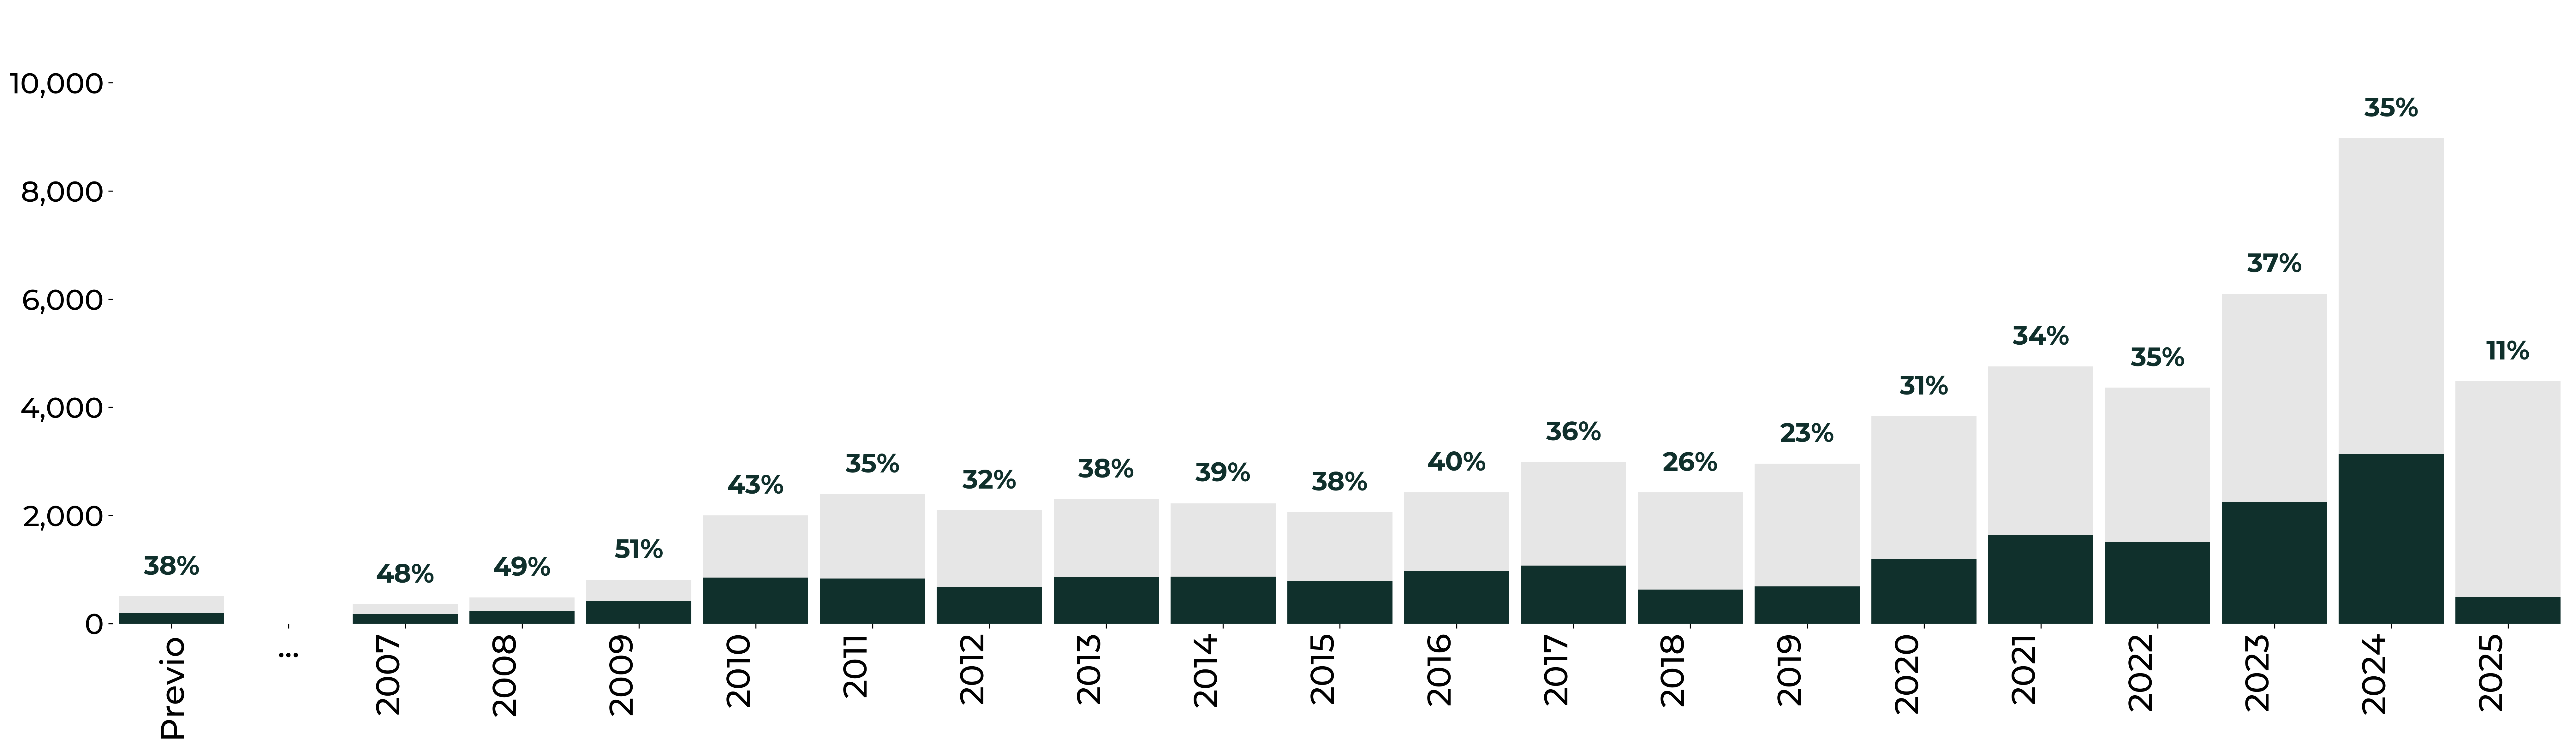

In [4]:
barras_apiladas(df1f, 
                nombre="df_fechas_long_vertical", 
                bar_height=0.9, 
                font='Montserrat',
                fontsize_barra=20,
                ordenar_por='etiqueta',
                orden='ascendente',
                valor_barra=False, 
                porcentaje_barra=False,
                porcentaje_total=False,
                orientacion='vertical',
                quitar_capsula=True,
                agregar_datos=[(pd.Timestamp(2005, 1, 1), "Previo", (192, 313, "38%"))],
                asignar_etiquetas='porcentaje',
                grillas=False,
                paleta_colores=["#10302C", "#E6E6E6"]
                )